In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading logins df
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


# Part One: Exploratory Data Analysis
#### Aggregate the logins on a 15 minute time interval
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [4]:
#creating new df
df.set_index('login_time', inplace=True)
df['count'] = 1
df.sort_index(inplace=True)
agg_df = df.resample("15min").sum()

In [5]:
agg_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


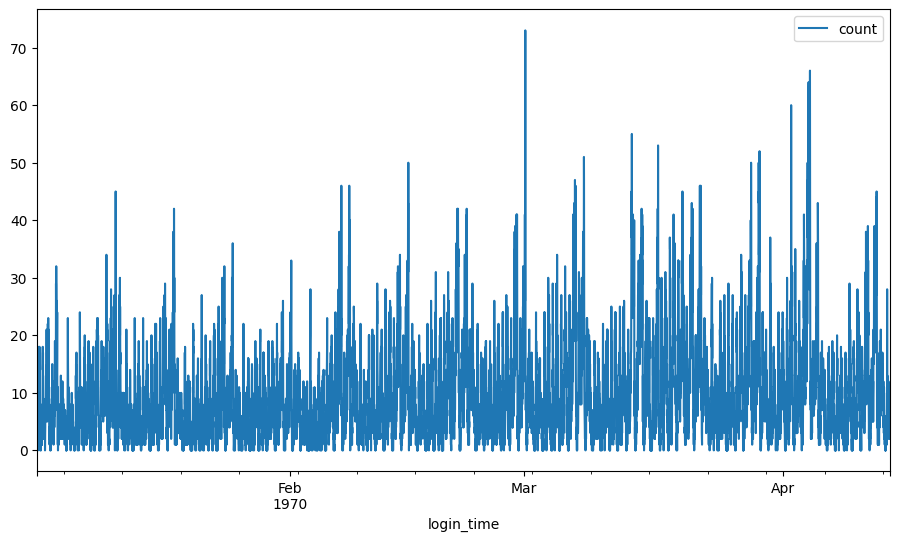

In [6]:
#intro glance at 15 minute intervals
agg_df.plot(kind='line',figsize=(11,6))
plt.show()

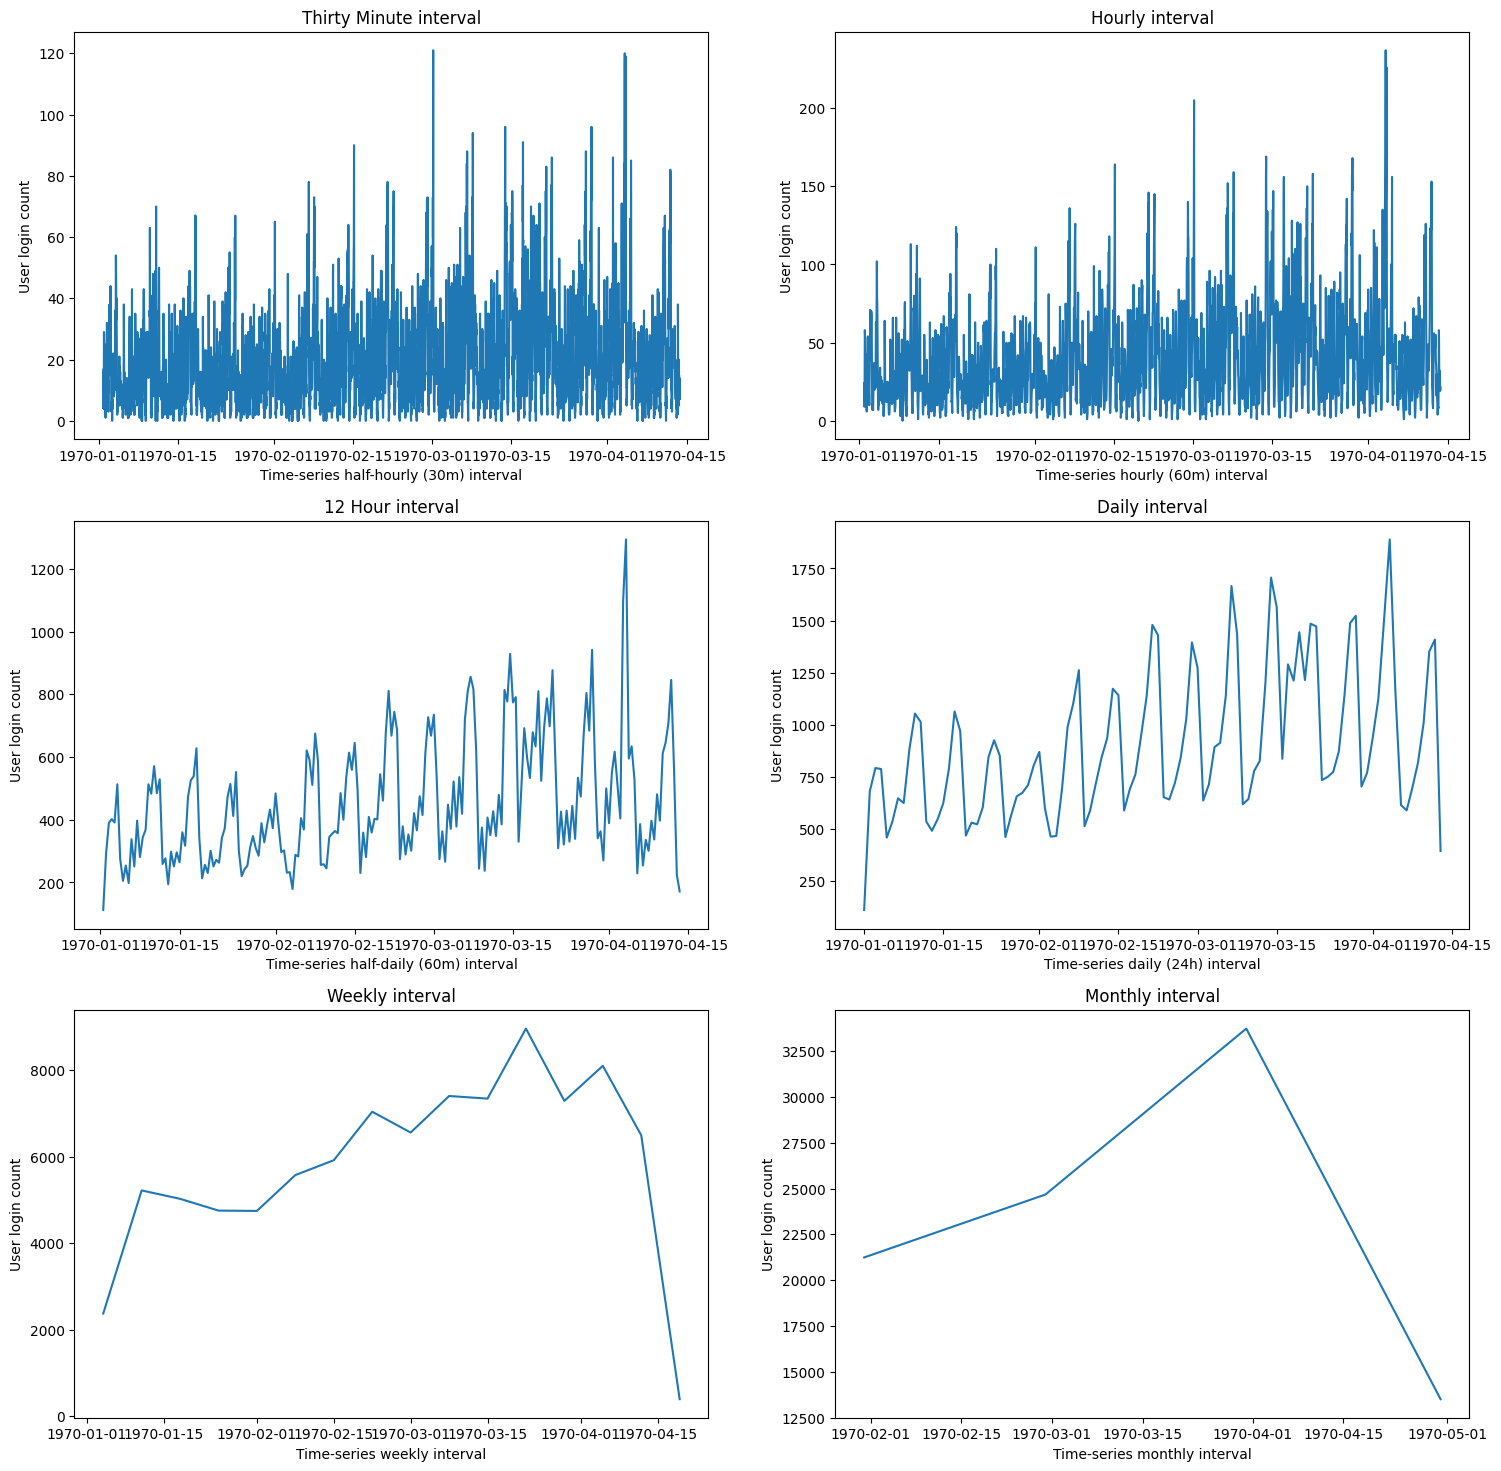

In [7]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(18,18));

# 30-min interval
ax1.plot(df.resample('30T').sum());
ax1.set(xlabel='Time-series half-hourly (30m) interval', ylabel='User login count', title='Thirty Minute interval')

# 60-min interval
ax2.plot(df.resample('60T').sum());
ax2.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# 12-Hour interval
ax3.plot(df.resample('.5D').sum());
ax3.set(xlabel='Time-series half-daily (60m) interval', ylabel='User login count', title='12 Hour interval')

# Daily interval
ax4.plot(df.resample('D').sum());
ax4.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax5.plot(df.resample('W').sum());
ax5.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax6.plot(df.resample('M').sum());
ax6.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

looks like there is definitely some seasonality, clearly visable on the 12 hour interval and daily interval. Once we go to weekly the seasonality disapears with a steady rise until the final month where we see a quick drop.

In [8]:
agg_df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Median is 7 but mean is 9.5 so the data is slightly skewed right

In [9]:
#adding in a weekday column
agg_df = agg_df.assign(weekday=agg_df.index.weekday)

In [10]:
#looking at the high count values
agg_df_high = agg_df.loc[agg_df['count'] > 45]
agg_df_high

,count,weekday
login_time,,
1970-02-07 04:30:00,46,5
1970-02-08 03:15:00,46,6
1970-02-15 04:45:00,50,6
1970-03-01 04:30:00,73,6
1970-03-01 04:45:00,48,6
1970-03-07 03:00:00,47,5
1970-03-07 04:45:00,46,5
1970-03-08 04:45:00,51,6
1970-03-08 05:00:00,47,6


Looks like at the beginning of the data we had weekly spikes until they dropped off mid march, on april 4th we had a large number of high values.

# Takeaways
There are two major takeaways. The first takeaway is the data show peaks every 12 hours so the seasonality runs on a 12 hour basis. Secondly the activity tends to increase over the course of the week although this trend began to fall off towards the end of the time period. We then had a steady high value in early april 

# Part Two - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
### Question One - What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric.
If we had access to this information (which we would if we were working for this company), the easiest key measure of success of this experiment would be "tolls reimbursed". This quite simply shows  that the drivers are moving from one city to the other. The hard thing about this since we are going from tolls not being reimbursed to tolls being reimbursed it will automatically be statiscally significant as it will jump from zero to something greater than zero. Unless we can gather data for how many bridge crossings are currently occuring, using this metric leaves alot to be desired. A better metric would be to track the drivers smartphones and use "% of time in each city". This would be data we have historically to compare to the new test with the toll reimbursements. It would both show that drivers are crossing and also how much time they are spending in each city.
### Question Two - Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a) how you will implement the experiment b) what statistical test(s) you will conduct to verify the significance of the observation c) how you would interpret the results and provide recommendations to the city operations team along with any caveats. 
Experiment Steps:
a) Take a random sample as large as is possible but no less than 100 drivers.
b) Get a average baseline percentage time that they spend in each city over the course of an entire week (look at multiple weeks and take mean).
c) Start the toll reimbursement policy, make sure drivers are aware of it and know the length of the policy
d) Take an average percentage time that the sample drivers spend in each city over the course of the program (look at all the weeks and average to per week).
e) Use a z-test and look for a confidence level (95) with H0 being there is no difference between the mean weekly percentage times of being in city A and Ha being there is a statiscally significant difference in the mean weekly percentage times of being in city A.
Make sure that these are regular weeks, no holidays or major events in the pre test sample nor the test sample. 

# Part Three - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention. (again a few sentances will suffice).

In [11]:
ddf = pd.read_json('ultimate_data_challenge.json')

In [12]:
ddf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
ddf.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [15]:
#creating df showing percent of users number of rides in first 30 days
ddf_trips = ddf['trips_in_first_30_days'].value_counts(normalize = True)*100
ddf_trips.head(8)

0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
7     1.638
Name: trips_in_first_30_days, dtype: float64

In [16]:
#shows percent of drivers that took at least one ride
np.sum(ddf_trips[1:])

C:\Users\colem\AppData\Local\Temp\ipykernel_18948\905724407.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  np.sum(ddf_trips[1:])


69.22

In [17]:
#dropping rows with no phone info, since that is what we need to infer from
ddf = ddf.drop(ddf[ddf.phone.isna()==True].index,axis=0)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [18]:
#filling remaining null values with average of those columns
ddf['avg_rating_by_driver'].fillna(ddf['avg_rating_by_driver'].mean(), inplace = True)
ddf['avg_rating_of_driver'].fillna(ddf['avg_rating_of_driver'].mean(), inplace = True)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [19]:
#changing dates to datetime value
ddf['last_trip_date'] = pd.to_datetime(ddf['last_trip_date'])
ddf['signup_date'] = pd.to_datetime(ddf['signup_date'])
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [20]:
#creating new df "last_date"
last_date = ddf['last_trip_date'].max()

#determine active users
ddf['active'] = ddf['last_trip_date'].apply(lambda date: 0 if (last_date-date).days>30 else 1)
ddf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [21]:
#Values of active/not active
ddf['active'].value_counts()

0    30933
1    18671
Name: active, dtype: int64

In [22]:
#percent of drivers active
18671/(18671+30933)*100

37.640109668575114

#### Question 1: 37.64% of users are active
After cleaning the data and then creating a new feature named "active" that determines if there has been a ride in the last 30 days we were able to determine the percent of active users

### Question 2: Build Predictive Model

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier

In [24]:
#dummy variables created for categorical features
ddf_features = pd.get_dummies(ddf, columns = ['city','phone','ultimate_black_user'])
ddf_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [25]:
#setting goal and dropping useless columns
goal = ddf_features['active']
ddf_features = ddf_features.drop(['last_trip_date','signup_date','active'],axis=1)
ddf_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [26]:
#scaling data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(ddf_features)

In [27]:
#splitting data for train and test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, goal, test_size = .2, random_state = 12)

In [29]:
#random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators =1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [30]:
#getting r_score for rf
rf.score(X_test, y_test)

0.7516379397238182

In [31]:
#getting cross validation score for rf
cv_score = cross_val_score(rf,X_test, np.ravel(y_test), cv = 5)
np.mean(cv_score)

0.7508307771999675

In [32]:
#getting feature importance for rf
rf_importance = pd.DataFrame(zip(list(ddf_features.columns),rf.feature_importances_),index=range(ddf_features.columns.shape[0]),columns=['feature','importance'])
rf_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.298724
4,weekday_pct,0.130948
6,avg_rating_by_driver,0.115243
1,avg_rating_of_driver,0.081715
0,trips_in_first_30_days,0.081064
3,surge_pct,0.079347
2,avg_surge,0.067621
8,city_King's Landing,0.048497
10,phone_Android,0.019362
11,phone_iPhone,0.019243


We have 3 very important features and 3 rather unimportant features. avg_dist, weekday_pct, avg_rating_by_driver all have importance over .1 and phone, black card, and city all have importance under .02

75% accuracy is pretty good. Will try logistic regression model (and hyperparameter tuning with gridsearchCV) to see if it improves

In [33]:
#initalizing model 
log_reg = LogisticRegression()
#setting grid
param_grid = {'C':np.arange(.5,5,.1)}
#instantiate and fit 
grid = GridSearchCV(log_reg, param_grid, cv = 5)
grid.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9])})

In [34]:
grid.best_estimator_.C

4.199999999999999

In [35]:
#finding coefficients from logistic regression
log_reg_coef = LogisticRegression(C=grid.best_estimator_.C)
log_reg_coef.fit(X_train, y_train)
ddf_coef = pd.DataFrame(zip(list(ddf_features.columns),log_reg_coef.coef_[0]),index=range(ddf_features.columns.shape[0]),columns=['feature','coefficient'])
ddf_coef

,feature,coefficient
0,trips_in_first_30_days,0.118376
1,avg_rating_of_driver,-0.287764
2,avg_surge,2.718521
3,surge_pct,-1.611568
4,weekday_pct,-0.236805
5,avg_dist,0.180738
6,avg_rating_by_driver,-1.351789
7,city_Astapor,-0.779452
8,city_King's Landing,1.118643
9,city_Winterfell,-0.266286


In [40]:
#getting r_score for log_reg
log_reg_coef.score(X_test, y_test)

0.7446829956657595

In [37]:
np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv = 5))

0.7422627874380434

Doesn't appear to have improved with logistic regression. Will try XGBoost as well

In [46]:
#fitting model to training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
xgb_importance = pd.DataFrame(zip(list(ddf_features.columns),xgb.feature_importances_),index=range(ddf_features.columns.shape[0]),columns=['feature','importance'])
xgb_importance.sort_values(by='importance',ascending=False)

,feature,importance
8,city_King's Landing,0.271995
10,phone_Android,0.173586
6,avg_rating_by_driver,0.159344
12,ultimate_black_user_False,0.091540
3,surge_pct,0.073495
7,city_Astapor,0.065200
4,weekday_pct,0.053777
0,trips_in_first_30_days,0.035038
2,avg_surge,0.022979
1,avg_rating_of_driver,0.022084


Interestingly we have different importance of features for XGboost compared to random forest. City (only for kings landing) is very important but city (winterfell) is not. Over all we have 3 features above an importance of .1 again, city (kings landing), phone (android), and avg rating by driver. We have 4 features below .02, avg_dist, city (winterfell), phone (iphone), and ultimate black card user (true)

In [52]:
y_pred = xgb.predict(X_test)
xgb.score(X_test, y_test)

0.7856062896885395

In [53]:
#getting cross validation score for rf
cv_score = cross_val_score(xgb,X_test, np.ravel(y_test), cv = 5)
np.mean(cv_score)

0.7662525392053303

XGBoost has a much better score than both logistic regression and random forest, and would be the model used in the future.